In [1]:
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split

import torch.nn as nn
import time
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML
from tabulate import tabulate
from IPython.display import clear_output
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data



import sys
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Experimental_setup")
from Experiment_v5 import Experiment
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Training")
from Training_Networks import Training
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Analysis")
from Check import Checkup



sys.path.append("/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis")
from Manifold_Analysis import Manifold_analysis



from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances

from matplotlib.ticker import NullFormatter
from collections import OrderedDict
from functools import partial
from sklearn import manifold, datasets

In [2]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)

    print(f'Random seed {seed} has been set.')

SEED = 2021
set_seed(seed=SEED)
# if gpu is to be used
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("Device: ", device)

G_SEED = torch.Generator()
G_SEED.manual_seed(SEED)

Device:  cpu
Random seed 2021 has been set.


# Multi

## Generate the Dataset

In [62]:
WIDTH = 100
BATCH_SIZE = 20
Names_hook = ["fc1","fc2","fc3"]
set_seed(seed=SEED)

experiment = Experiment(width = WIDTH,batch_size=BATCH_SIZE,size_output_multi = 2)


dataset_train,dataset_space_train,dataset_weather_train,dataset_val,dataset_space_val,dataset_weather_val,dataset_test,dataset_space_test,dataset_weather_test= experiment.Generate_data()
train_loader = torch.utils.data.DataLoader(dataset_train,batch_size=BATCH_SIZE,shuffle = False )
val_loader = torch.utils.data.DataLoader(dataset_val,batch_size=BATCH_SIZE,shuffle = False )
test_loader_multi = torch.utils.data.DataLoader(dataset_test,batch_size=1,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE

Random seed 2021 has been set.
Test size dataset space torch.Size([999, 6])
Test size dataset weather torch.Size([999, 6])
Train size dataset space torch.Size([7000, 6])
Train size dataset weather torch.Size([7000, 6])


## Analyse Parameters

In [63]:
do_analysis  = True
type = 1
frequence = 20

# Multi

## Parameters Network

In [119]:
class Training():
    
    def __init__(self):
        pass
    
    def training_individual(self,model,Input_Dimension,Nodes_Second,Nodes_Third,Epoch,train_loader,val_loader):
        
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        criterion = nn.BCEWithLogitsLoss()
        losses = []
        val_losses = []

        for epoch in range(Epoch):

            loss = 0
            val_loss = 0 

            for x_batch, y_batch in train_loader:

                #x_batch = x_batch[:,0:5]
                optimizer.zero_grad()
                output, hidden = model(x_batch)
               # print("output",output.shape)

                #output = output.squeeze(1)
                output_loss = criterion(output,y_batch)
                output_loss.backward()
                optimizer.step()

                loss += output_loss.detach().numpy()
            losses.append(loss/len(train_loader))

            with torch.no_grad():
                for x_val, y_val in val_loader:
                    model.eval() 
                   # x_val = x_val[:,0:5]
                    yhat,_ = model(x_val)
                    val_loss += criterion(yhat,y_val)
                val_losses.append(val_loss.item()/len(val_loader))


            if np.mod(epoch,10)==0: 
                clear_output()
                print("Epoch {}, val_loss {}".format(epoch, val_loss.item()/len(val_loader))) 
                fig = plt.figure()
                ax = fig.add_subplot(111)
                plt.plot(np.arange(len(val_losses)), val_losses)
                plt.ylabel('Loss')
                plt.xlabel('Epoch #')
                plt.show()
       
        return model,val_losses

In [120]:
Input_Dimension = 6
Output_Dimension = 2
Hidden_Dimension = 20
N_Layers = 1

In [126]:
from torch import nn

class Model_RNN(nn.Module):
    
    def __init__(self,input_size,output_size,hidden_dim, n_layers):
        
        super(Model_RNN,self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size,hidden_dim, n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_size)
        
        
    def forward(self,x):
        x = torch.reshape(x,(x.size(0),1,6))
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out,hidden = self.rnn(x,hidden)
        out = out.contiguous().view(-1,self.hidden_dim)
        out = self.fc(out)
        
        
        return out, hidden
   
    def init_hidden(self,batch_size):
        hidden = torch.zeros(self.n_layers,batch_size,self.hidden_dim)
        
        return hidden

In [127]:
model = Model_RNN(Input_Dimension,Output_Dimension,Hidden_Dimension,N_Layers)
print(model)

Model_RNN(
  (rnn): RNN(6, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=2, bias=True)
)


## Train network and visualize representation every N epochs

Epoch 490, val_loss 0.020317301750183106


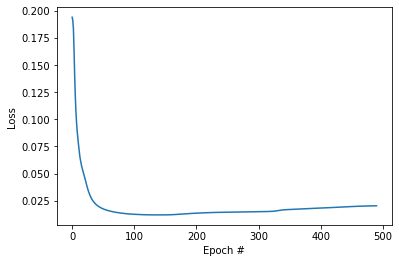

In [128]:
EPOCH = 500
Multi_losses = []
representation_analysis = False

training = Training()
model,val_losses = training.training_individual(model,Input_Dimension,Nodes_Second,Nodes_Third,EPOCH,train_loader,val_loader)
Multi_losses.append(val_losses)
            

In [132]:
for x_test,y_test in test_loader_multi:
    with torch.no_grad():
        model.eval() 
        yhat,_ = model(x_test)
        yhat = torch.nn.Sigmoid()(yhat)
        print(yhat)
        print(y_test)

tensor([[1.8810e-14, 5.2815e-07]])
tensor([[0., 0.]])
tensor([[1.1945e-17, 1.0850e-05]])
tensor([[0., 0.]])
tensor([[4.5954e-24, 2.5183e-07]])
tensor([[0., 0.]])
tensor([[4.8612e-07, 6.7113e-04]])
tensor([[0., 0.]])
tensor([[6.6453e-23, 1.0381e-18]])
tensor([[0., 0.]])
tensor([[5.0042e-21, 2.1808e-05]])
tensor([[0., 0.]])
tensor([[6.0892e-20, 1.2526e-05]])
tensor([[0., 0.]])
tensor([[1.0354e-19, 4.1129e-18]])
tensor([[0., 0.]])
tensor([[4.4349e-18, 5.6765e-05]])
tensor([[0., 0.]])
tensor([[2.6616e-18, 3.9963e-12]])
tensor([[0., 0.]])
tensor([[1.7631e-18, 1.1048e-08]])
tensor([[0., 0.]])
tensor([[1.2930e-15, 5.4510e-18]])
tensor([[0., 0.]])
tensor([[5.3008e-14, 4.6993e-04]])
tensor([[0., 0.]])
tensor([[2.4886e-19, 2.7982e-06]])
tensor([[0., 0.]])
tensor([[6.8325e-15, 4.9946e-05]])
tensor([[0., 0.]])
tensor([[2.8371e-12, 2.0182e-05]])
tensor([[0., 0.]])
tensor([[2.8434e-19, 7.9722e-06]])
tensor([[0., 0.]])
tensor([[4.9376e-17, 2.0965e-04]])
tensor([[0., 0.]])
tensor([[3.7591e-14, 9.9999e

tensor([[5.0047e-15, 4.9930e-05]])
tensor([[0., 0.]])
tensor([[5.6108e-05, 2.6114e-18]])
tensor([[0., 0.]])
tensor([[4.3595e-16, 5.3599e-18]])
tensor([[0., 0.]])
tensor([[6.7204e-12, 1.0797e-04]])
tensor([[0., 0.]])
tensor([[2.8808e-21, 1.7822e-06]])
tensor([[0., 0.]])
tensor([[3.9219e-16, 2.5041e-17]])
tensor([[0., 0.]])
tensor([[3.2732e-19, 3.6074e-05]])
tensor([[0., 0.]])
tensor([[3.0024e-17, 1.6699e-05]])
tensor([[0., 0.]])
tensor([[6.3048e-18, 9.4884e-01]])
tensor([[0., 1.]])
tensor([[2.8965e-10, 2.1627e-03]])
tensor([[0., 0.]])
tensor([[2.8761e-17, 8.3897e-18]])
tensor([[0., 0.]])
tensor([[5.7035e-15, 4.3947e-18]])
tensor([[0., 0.]])
tensor([[1.0000e+00, 1.7336e-14]])
tensor([[1., 0.]])
tensor([[7.9809e-17, 1.0758e-04]])
tensor([[0., 0.]])
tensor([[2.5772e-15, 4.9265e-04]])
tensor([[0., 0.]])
tensor([[4.5531e-13, 2.5662e-17]])
tensor([[0., 0.]])
tensor([[1.0000e+00, 1.7781e-07]])
tensor([[1., 0.]])
tensor([[4.5221e-13, 5.3813e-16]])
tensor([[0., 0.]])
tensor([[2.8096e-13, 1.1335e

tensor([[0., 0.]])
tensor([[4.2924e-12, 1.5301e-09]])
tensor([[0., 0.]])
tensor([[6.1490e-11, 1.5129e-18]])
tensor([[0., 0.]])
tensor([[1.0000e+00, 6.0093e-09]])
tensor([[1., 0.]])
tensor([[1.0000e+00, 3.7033e-20]])
tensor([[1., 0.]])
tensor([[1.0000e+00, 1.6072e-19]])
tensor([[1., 0.]])
tensor([[1.0000e+00, 4.7638e-12]])
tensor([[1., 0.]])
tensor([[2.1157e-15, 4.9003e-05]])
tensor([[0., 0.]])
tensor([[2.7277e-23, 1.4633e-04]])
tensor([[0., 0.]])
tensor([[3.2156e-13, 3.9331e-19]])
tensor([[0., 0.]])
tensor([[7.7684e-18, 1.9380e-05]])
tensor([[0., 0.]])
tensor([[7.9906e-16, 2.3870e-14]])
tensor([[0., 0.]])
tensor([[1.3442e-10, 5.8891e-06]])
tensor([[0., 0.]])
tensor([[3.2118e-21, 1.5219e-05]])
tensor([[0., 0.]])
tensor([[6.0436e-11, 6.2199e-05]])
tensor([[0., 0.]])
tensor([[3.7985e-17, 8.0870e-06]])
tensor([[0., 0.]])
tensor([[3.3324e-18, 1.9122e-04]])
tensor([[0., 0.]])
tensor([[3.1630e-15, 5.4913e-03]])
tensor([[0., 0.]])
tensor([[5.2800e-16, 9.1378e-05]])
tensor([[0., 0.]])
tensor([[

tensor([[5.1981e-13, 1.1078e-18]])
tensor([[0., 0.]])
tensor([[3.3032e-06, 5.5839e-03]])
tensor([[0., 0.]])
tensor([[6.3003e-15, 1.7400e-05]])
tensor([[0., 0.]])
tensor([[1.3600e-16, 2.1607e-05]])
tensor([[0., 0.]])
tensor([[9.6620e-18, 1.2050e-14]])
tensor([[0., 0.]])
tensor([[1.4291e-15, 4.3451e-05]])
tensor([[0., 0.]])
tensor([[4.4424e-06, 1.6715e-07]])
tensor([[0., 0.]])
tensor([[8.8564e-12, 3.8007e-05]])
tensor([[0., 0.]])
tensor([[1.3263e-18, 9.5273e-06]])
tensor([[0., 0.]])
tensor([[4.0891e-17, 3.5536e-06]])
tensor([[0., 0.]])
tensor([[2.1966e-15, 7.1805e-05]])
tensor([[0., 0.]])
tensor([[2.3883e-17, 6.4128e-09]])
tensor([[0., 0.]])
tensor([[3.4154e-09, 6.6410e-09]])
tensor([[0., 0.]])
tensor([[1.0000e+00, 5.9174e-07]])
tensor([[1., 0.]])
tensor([[1.3138e-16, 1.3715e-17]])
tensor([[0., 0.]])
tensor([[2.9465e-17, 2.1644e-17]])
tensor([[0., 0.]])
tensor([[2.2639e-12, 3.3155e-18]])
tensor([[0., 0.]])
tensor([[1.0000e+00, 4.9074e-10]])
tensor([[1., 0.]])
tensor([[1.0000e+00, 7.2093e

## WEATHER

In [4]:
train_loader = torch.utils.data.DataLoader(dataset_weather_train,batch_size=BATCH_SIZE,shuffle = False )
val_loader = torch.utils.data.DataLoader(dataset_weather_val,batch_size=BATCH_SIZE,shuffle = False )
test_loader_weather = torch.utils.data.DataLoader(dataset_weather_test,batch_size=1,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE

In [5]:
Nodes_Second = 20
Nodes_Third = 5
Output_Dimension = 2

In [ ]:
EPOCH = 500
Weather_losses = []

training = Training()
model,val_losses = training.training_individual(5,Nodes_Second,Nodes_Third,EPOCH,train_loader,val_loader,test_loader_weather,do_analysis,"Weather")
Weather_losses.append(val_losses)

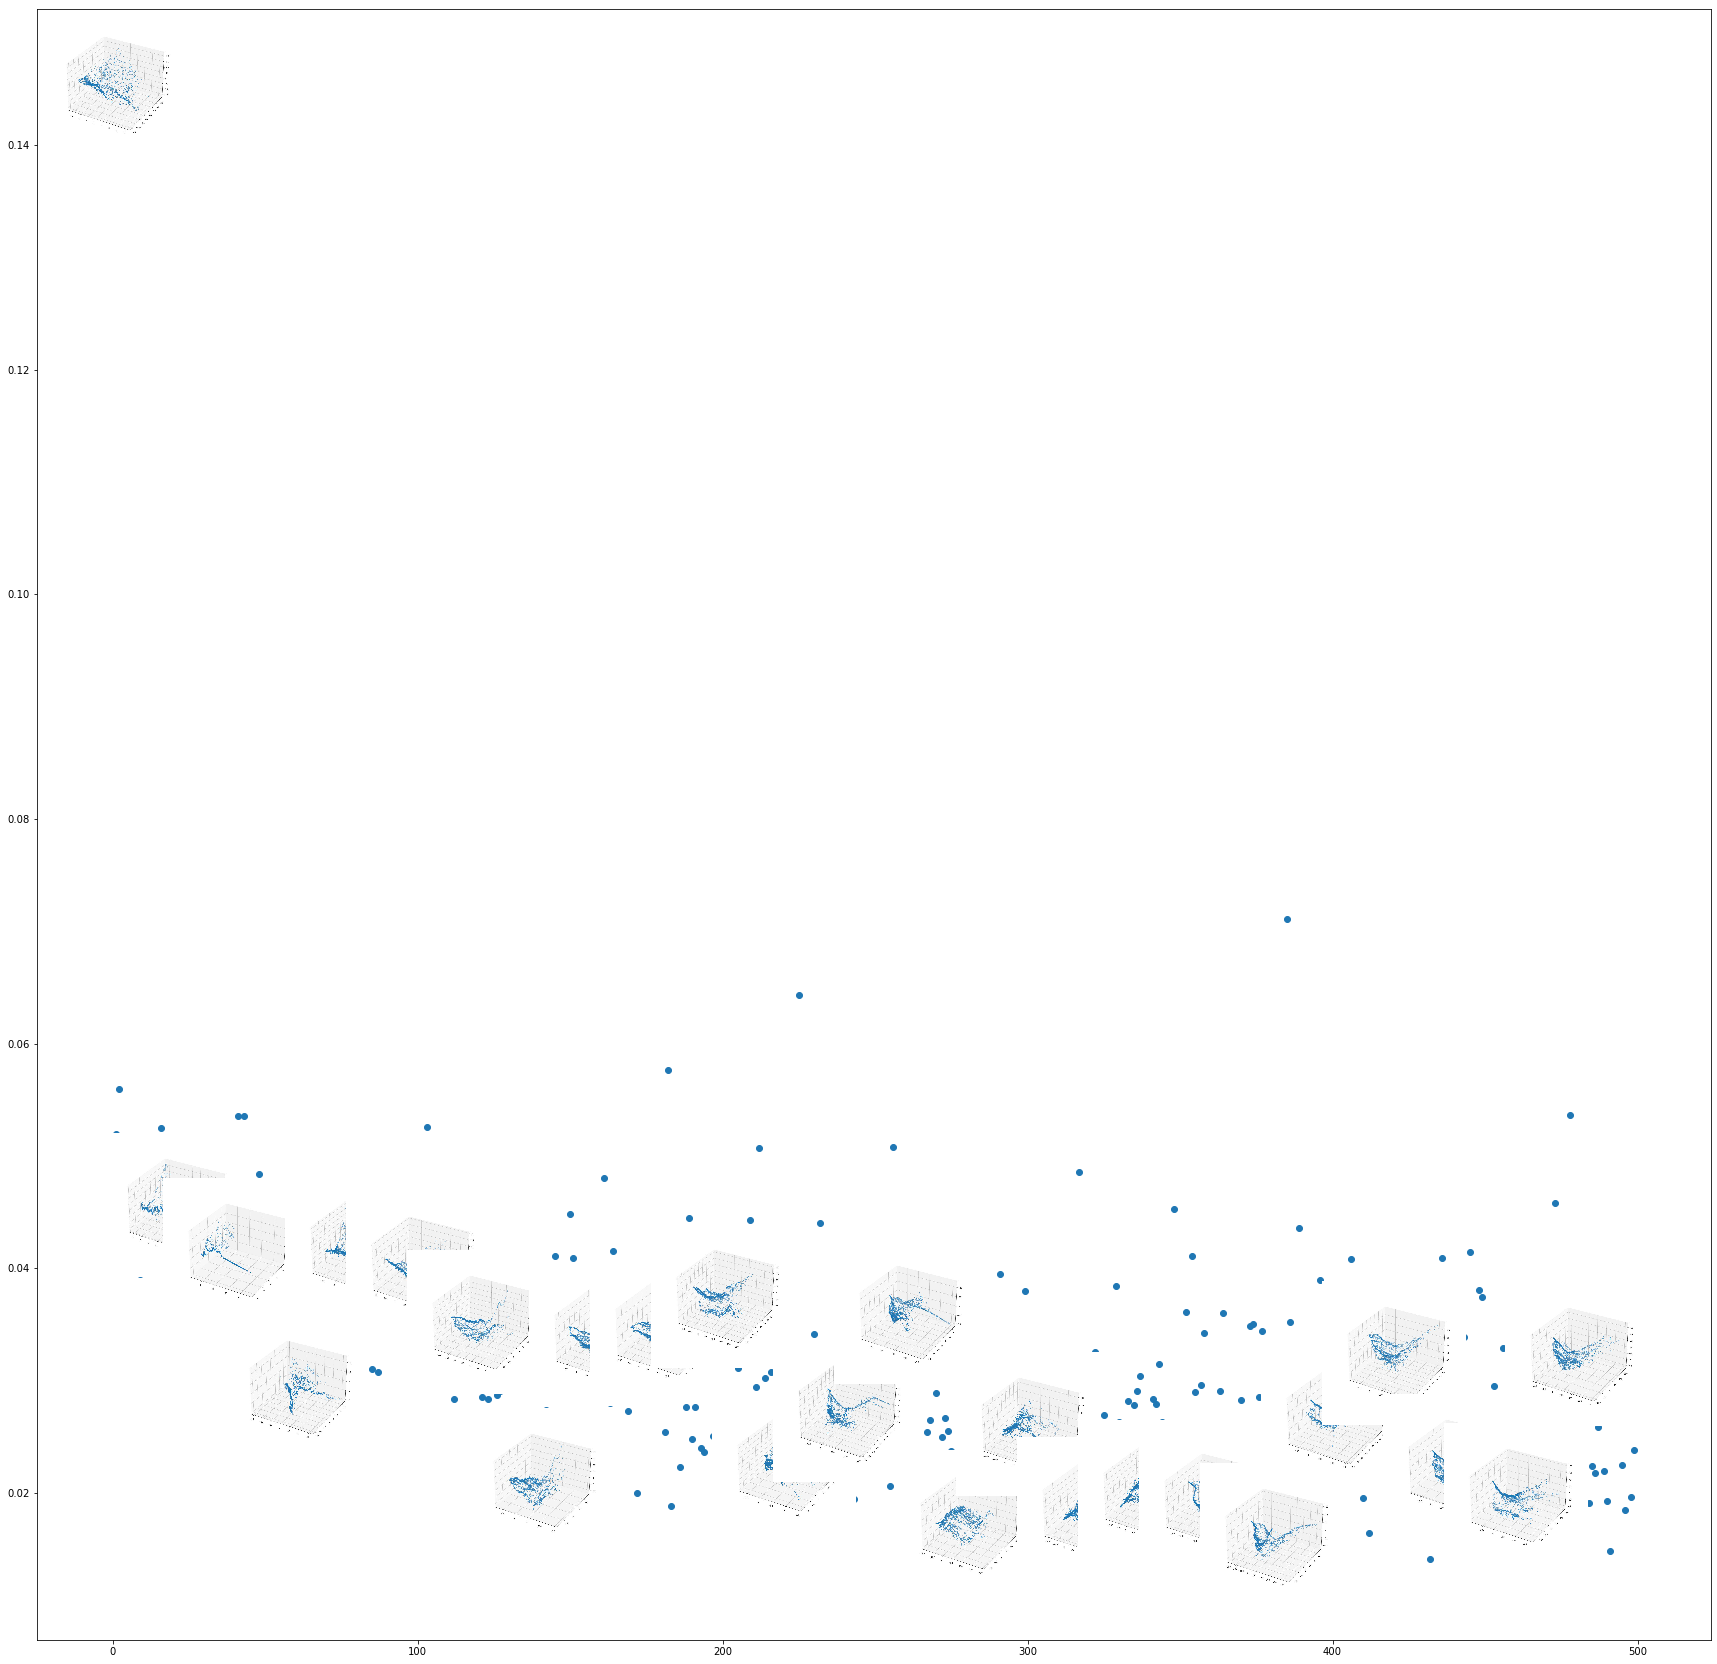

In [9]:
epochs = [i for i in range(len(val_losses))]
parent_dir = "/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Result_learning_representation"

def main(x,y):
    fig, ax = plt.subplots(figsize=(30,30))
    imscatter(x,y,  zoom=0.2, ax=ax)
    ax.scatter(x,y ,marker='o')   
    plt.show()

def imscatter(x, y, ax=None, zoom=1):
    x, y = np.atleast_1d(x, y)
    artists = []
    i = 0
    for x0, y0 in zip(x, y):
        if np.mod(i,20) == 0:
            image = os.path.join(parent_dir,"Weather","fc2","step_"+str(i)+".jpg")
            if ax is None:
                ax = plt.gca()
            try:
                image = plt.imread(image)
            except TypeError:
                # Likely already an array.''..
                pass
            im = OffsetImage(image, zoom=zoom)
            ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
        i+=1
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

main(epochs,val_losses)

In [12]:
## SPATIAL

In [10]:
train_loader = torch.utils.data.DataLoader(dataset_space_train,batch_size=BATCH_SIZE,shuffle = False )
val_loader = torch.utils.data.DataLoader(dataset_space_val,batch_size=BATCH_SIZE,shuffle = False )
test_loader_space = torch.utils.data.DataLoader(dataset_space_test,batch_size=1,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE

In [ ]:
EPOCH = 500
Spatial_losses = []
training = Training()
model,val_losses = training.training_individual(5,Nodes_Second,Nodes_Third,EPOCH,train_loader,val_loader,test_loader_space,do_analysis,"Spatial")
Spatial_losses.append(val_losses)

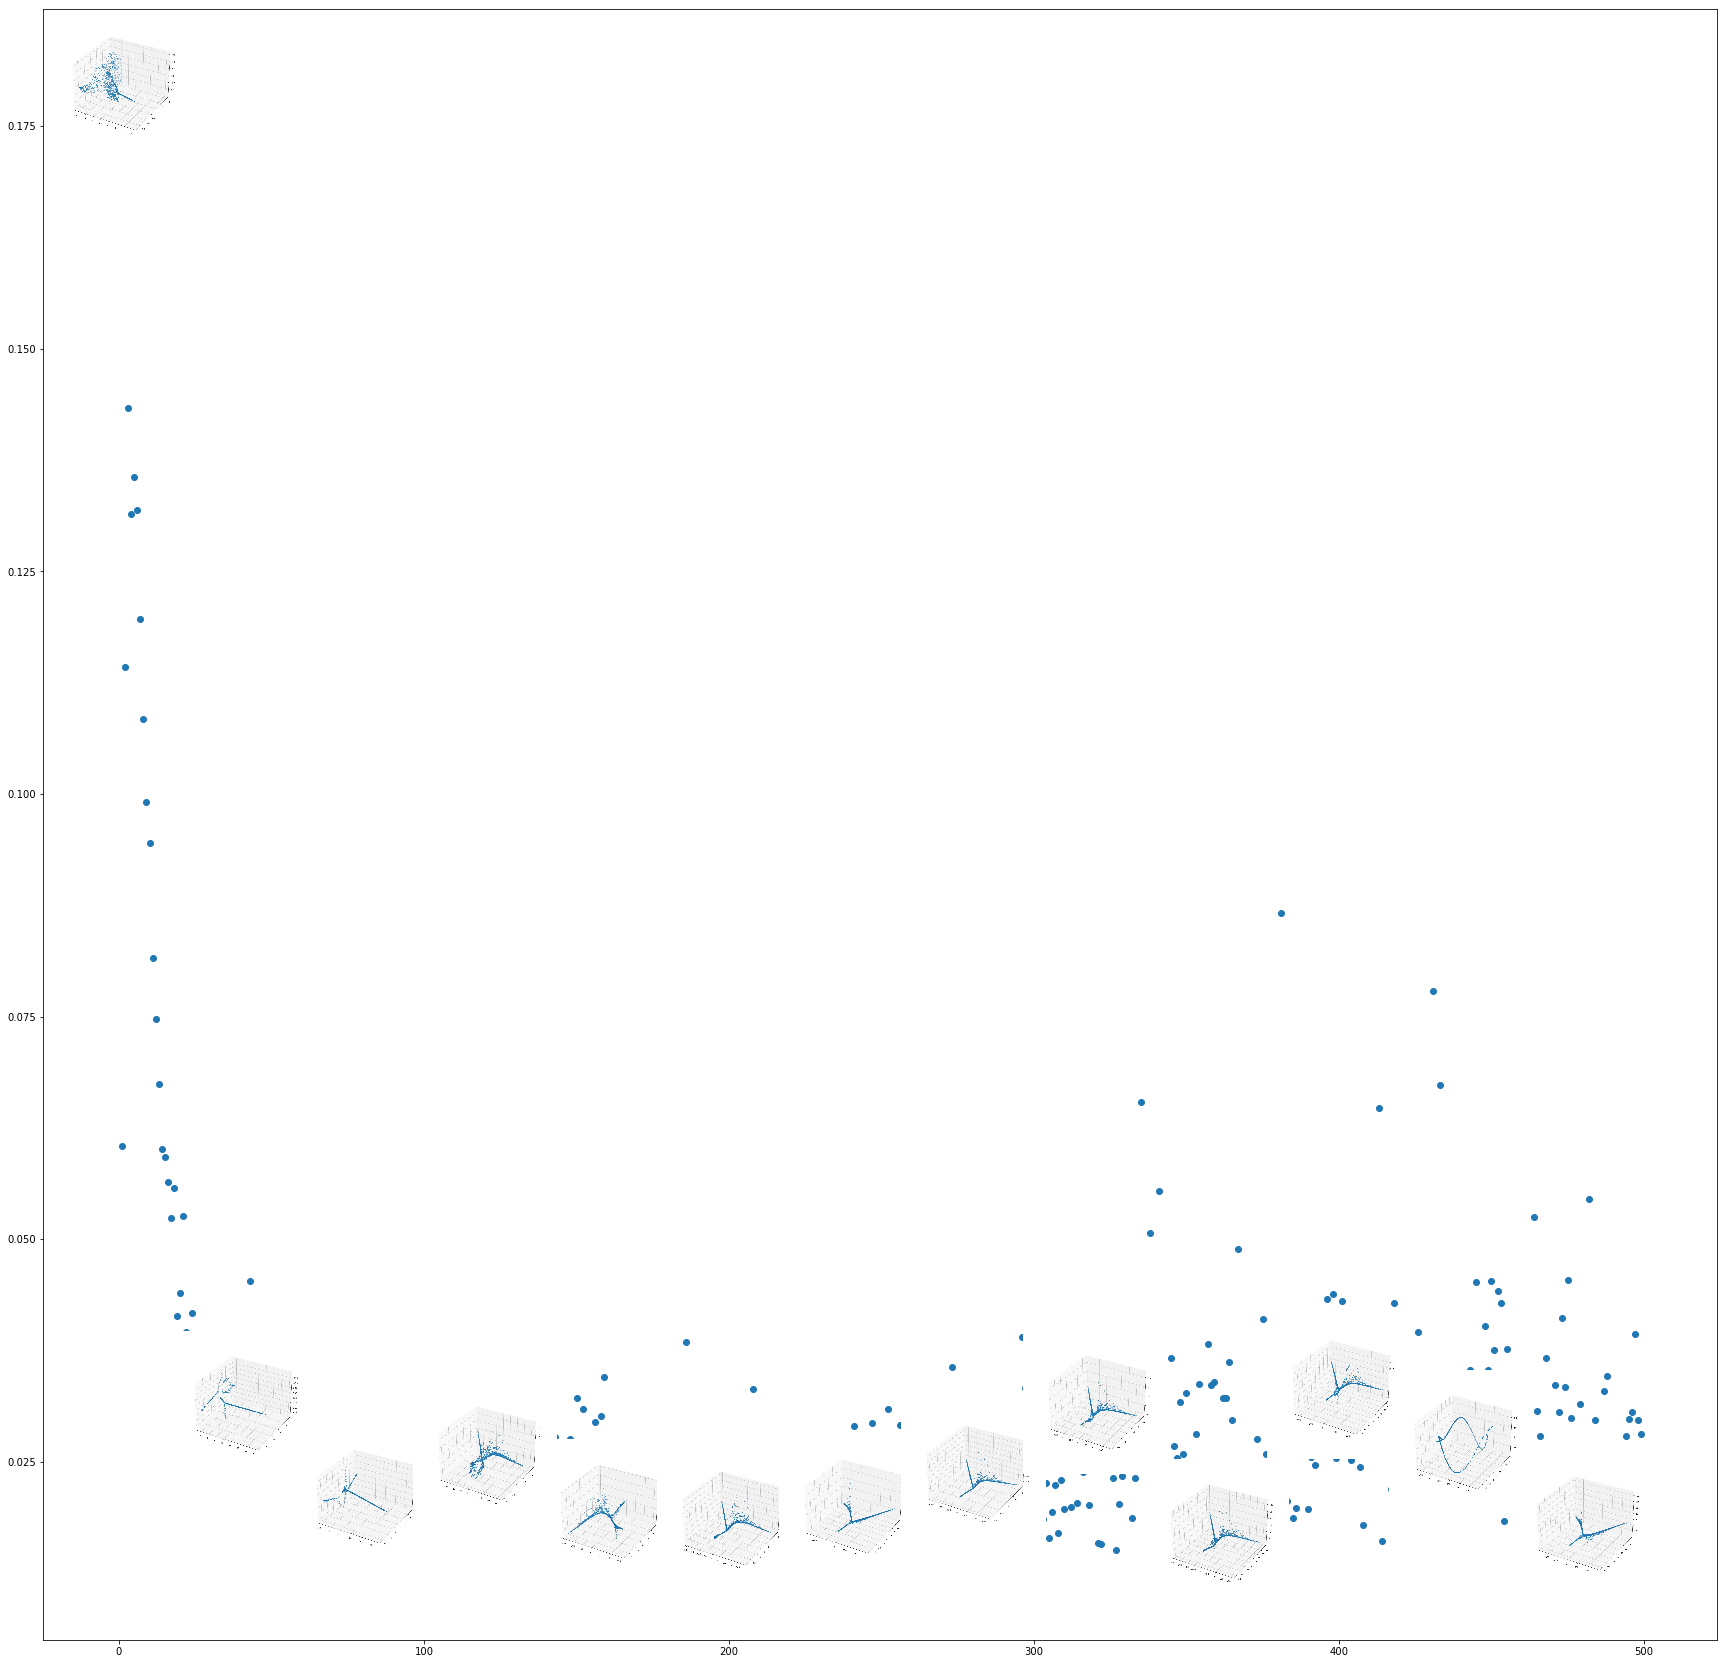

In [13]:
epochs = [i for i in range(len(val_losses))]
parent_dir = "/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Result_learning_representation"

def main(x,y):
    fig, ax = plt.subplots(figsize=(30,30))
    imscatter(x,y,  zoom=0.2, ax=ax)
    ax.scatter(x,y ,marker='o')   
    plt.show()

def imscatter(x, y, ax=None, zoom=1):
    x, y = np.atleast_1d(x, y)
    artists = []
    i = 0
    for x0, y0 in zip(x, y):
        if np.mod(i,40) == 0:
            image = os.path.join(parent_dir,"Spatial","fc2","step_"+str(i)+".jpg")
            if ax is None:
                ax = plt.gca()
            try:
                image = plt.imread(image)
            except TypeError:
                # Likely already an array.''..
                pass
            im = OffsetImage(image, zoom=zoom)
            ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
        i+=1
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

main(epochs,val_losses)